## Machine Learning Avanzado
#### Redes Recursivas y Recurrentes

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Parametros iniciales
velocidadDeAprendizaje = 0.001
numeroDeIteracionesEntrenamiento = 5000
iteracionesMostrarInfo = 1000
numeroEntradas = 3

# Numero de unidades ocultas en una celda RNN
hidden = 512

In [2]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [3]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]


In [4]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)


938/938 [==============================] - 16s 14ms/step - loss: 0.9545 - accuracy: 0.7004 - val_loss: 0.5849 - val_accuracy: 0.8054


In [5]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)


938/938 [==============================] - 15s 14ms/step - loss: 0.4023 - accuracy: 0.8810 - val_loss: 0.3706 - val_accuracy: 0.8829


Predicted result is: [3], target result is: 5
(28, 28)


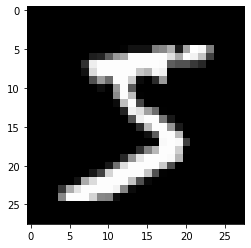

In [9]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

print(sample.shape)


In [7]:
import sys
path_to_module = "/home/tom/miniconda3/envs/MachineLearning/lib/python3.10/site-packages/"
sys.path.append(path_to_module)
import cv2

TypeError: Image data of dtype object cannot be converted to float

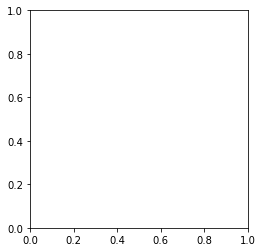

In [8]:
file = '/media/tom/Fonte Storage/00 Clases/UDD/MLA/Laboratorios/5.png'
test_image = cv2.imread(file,cv2.IMREAD_GRAYSCALE)
plt.imshow(test_image,cmap='gray')

In [ ]:
img_resized = cv2.resize(test_image,(28,28),interpolation = cv2.INTER_LINEAR)
img_resized = cv2.bitwise_not(img_resized)
plt.imshow(img_resized,cmap='gray')

In [ ]:
sample_label = 3#

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(img_resized, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))


### Redes Recursivas


In [ ]:
# Primero hay que representar el arbol de la estructura de datos en un grafico

class Node:  # a node in the tree
    def __init__(self, ...):
        self.isLeaf = True / False
        self.hidden_state = None
        # for leaves
        self.word = word
        # for inner nodes
        self.left = None  # reference to left child
        self.right = None  # reference to right child
#...

In [ ]:
class RNN_Model():
    def add_model_vars(self):
        with tf.variable_scope('Embeddings'):
            embeddings = \
            tf.get_variable('embeddings', [len(self.vocab), self.config.embed_size])
            with tf.variable_scope('Composition'):
                W1 = tf.get_variable('W1',
                                     [2 * self.config.embed_size, self.config.embed_size])
                b1 = tf.get_variable('b1', [1, self.config.embed_size])
            with tf.variable_scope('Projection'):
                U = tf.get_variable('U', [self.config.embed_size, self.config.label_size])
                bs = tf.get_variable('bs', [1, self.config.label_size])

In [ ]:
import os, sys,shutil,time,itertools
import math, random
from collections import OrderedDict, defaultdict

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import utils
import tree


class Config(object):
    """Holds model hyperparams and data information.
    Model objects are passed a Config() object at instantiation.
    """
    
    embed_size = 35
    label_size = 2
    early_stopping = 2
    anneal_threshold = 0.99
    anneal_by = 1.5
    max_epochs = 30
    lr = 0.01
    l2 = 0.02
    
    model_name = MODEL_STR % (embed_size, l2, lr)


class RecursiveNetStaticGraph():
    
    def __init__(self, config):
        self.config = config
        
        # Load train data and build vocabulary
        self.train_data, self.dev_data, self.test_data = tree.simplified_data(700,
                                                                              100,
                                                                              200)
        
        # print("data ",self.train_data)
        self.vocab = utils.Vocab()
        train_sents = [t.get_words() for t in self.train_data]
        self.vocab.construct(list(itertools.chain.from_iterable(train_sents)))
        
        # add input placeholders
        self.is_leaf_placeholder = tf.placeholder(
            tf.bool, (None), name='is_leaf_placeholder')
        self.left_children_placeholder = tf.placeholder(
            tf.int32, (None), name='left_children_placeholder')
        self.right_children_placeholder = tf.placeholder(
            tf.int32, (None), name='right_children_placeholder')
        self.node_word_indices_placeholder = tf.placeholder(
            tf.int32, (None), name='node_word_indices_placeholder')
        self.labels_placeholder = tf.placeholder(
            tf.int32, (None), name='labels_placeholder')
        
        # add model variables
        with tf.variable_scope('Embeddings'):
            embeddings = tf.get_variable('embeddings',
                                         [len(self.vocab), self.config.embed_size])
        with tf.variable_scope('Composition'):
            W1 = tf.get_variable('W1',
                                 [2 * self.config.embed_size, self.config.embed_size])
            b1 = tf.get_variable('b1', [1, self.config.embed_size])
        with tf.variable_scope('Projection'):
            U = tf.get_variable('U', [self.config.embed_size, self.config.label_size])
            bs = tf.get_variable('bs', [1, self.config.label_size])
            
        # build recursive graph
        
        tensor_array = tf.TensorArray(
            tf.float32,
            size=0,
            dynamic_size=True,
            clear_after_read=False,
            infer_shape=False)
        
        def embed_word(word_index):
            with tf.device('/cpu:0'):
                return tf.expand_dims(tf.gather(embeddings, word_index), 0)

    def combine_children(left_tensor, right_tensor):
        return tf.nn.relu(tf.matmul(tf.concat([left_tensor, right_tensor],1), W1) + b1)
    
    def loop_body(tensor_array, i):
        node_is_leaf = tf.gather(self.is_leaf_placeholder, i)
        node_word_index = tf.gather(self.node_word_indices_placeholder, i)
        left_child = tf.gather(self.left_children_placeholder, i)
        right_child = tf.gather(self.right_children_placeholder, i)
        print(left_child,"left_child")
        node_tensor = tf.cond(
            node_is_leaf,
            lambda: embed_word(node_word_index),
            lambda: combine_children(tensor_array.read(left_child),
                                     tensor_array.read(right_child)))
        tensor_array = tensor_array.write(i, node_tensor)
        i = tf.add(i, 1)
        return tensor_array, i
    
    loop_cond = lambda tensor_array, i: \
        tf.less(i, tf.squeeze(tf.shape(self.is_leaf_placeholder)))
    self.tensor_array, _ = tf.while_loop(loop_cond, loop_body, [tensor_array, 0], parallel_iterations=1)
    
    # add projection layer
    self.logits = tf.matmul(self.tensor_array.concat(), U) + bs
    self.root_logits = tf.matmul(
        self.tensor_array.read(self.tensor_array.size() - 1), U) + bs
    self.root_prediction = tf.squeeze(tf.argmax(self.root_logits, 1))
    
    # add loss layer
    regularization_loss = self.config.l2 * (
        tf.nn.l2_loss(W1) + tf.nn.l2_loss(U))
    included_indices = tf.where(tf.less(self.labels_placeholder, 2))
    self.full_loss = regularization_loss + tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=tf.gather(self.logits, included_indices),labels=tf.gather(
                self.labels_placeholder, included_indices)))
    self.root_loss = tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=self.root_logits,labels=self.labels_placeholder[-1:]))
    
    # add training op
    self.train_op = tf.train.GradientDescentOptimizer(self.config.lr).minimize(
        self.full_loss)
    
    def build_feed_dict(self, node):
        nodes_list = []
        tree.leftTraverse(node, lambda node, args: args.append(node), nodes_list)
        node_to_index = OrderedDict()
        for i in xrange(len(nodes_list)):
            node_to_index[nodes_list[i]] = i
        feed_dict = {
            self.is_leaf_placeholder: [node.isLeaf for node in nodes_list],
            self.left_children_placeholder: [node_to_index[node.left] if
                                             not node.isLeaf else -1
                                             for node in nodes_list],
            self.right_children_placeholder: [node_to_index[node.right] if
                                              not node.isLeaf else -1
                                              for node in nodes_list],
            self.node_word_indices_placeholder: [self.vocab.encode(node.word) if
                                                 node.word else -1
                                                 for node in nodes_list],
            self.labels_placeholder: [node.label for node in nodes_list]
        }
        return feed_dict
    
    def predict(self, trees, weights_path, get_loss=False):
        """Make predictions from the provided model."""
        results = []
        losses = []
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess, weights_path)
            for tree in trees:
                feed_dict = self.build_feed_dict(tree.root)
                if get_loss:
                    root_prediction, loss = sess.run(
                        [self.root_prediction, self.root_loss], feed_dict=feed_dict)
                    losses.append(loss)
                else:
                    root_prediction = sess.run(self.root_prediction, feed_dict=feed_dict)
                    results.append(root_prediction)
            return results, losses

    def run_epoch(self, new_model=False, verbose=True):
        loss_history = []
        # training
        random.shuffle(self.train_data)
        with tf.Session() as sess:
            if new_model:
                sess.run(tf.initialize_all_variables())
            else:
                saver = tf.train.Saver()
                saver.restore(sess, SAVE_DIR + '%s.temp' % self.config.model_name)
            for step, tree in enumerate(self.train_data):
                print(tree,"tree")
                feed_dict = self.build_feed_dict(tree.root)
                loss_value, _ = sess.run([self.full_loss, self.train_op],
                                         feed_dict=feed_dict)
                loss_history.append(loss_value)
                if verbose:
                    sys.stdout.write('\r{} / {} :    loss = {}'.format(step, len(
                        self.train_data), np.mean(loss_history)))
                    sys.stdout.flush()
                    saver = tf.train.Saver()
                    if not os.path.exists(SAVE_DIR):
                        os.makedirs(SAVE_DIR)
                    saver.save(sess, SAVE_DIR + '%s.temp' % self.config.model_name)
            # statistics
            train_preds, _ = self.predict(self.train_data,
                                          SAVE_DIR + '%s.temp' % self.config.model_name)
            val_preds, val_losses = self.predict(
                self.dev_data,
                SAVE_DIR + '%s.temp' % self.config.model_name,
                get_loss=True)
            train_labels = [t.root.label for t in self.train_data]
            val_labels = [t.root.label for t in self.dev_data]
            train_acc = np.equal(train_preds, train_labels).mean()
            val_acc = np.equal(val_preds, val_labels).mean()
            
            print()
            print( 'Training acc (only root node): {}'.format(train_acc))
            print( 'Valiation acc (only root node): {}'.format(val_acc))
            print( self.make_conf(train_labels, train_preds))
            print( self.make_conf(val_labels, val_preds))
            return train_acc, val_acc, loss_history, np.mean(val_losses)

    def train(self, verbose=True):
        complete_loss_history = []
        train_acc_history = []
        val_acc_history = []
        prev_epoch_loss = float('inf')
        best_val_loss = float('inf')
        best_val_epoch = 0
        stopped = -1
        for epoch in xrange(self.config.max_epochs):
            print( 'epoch %d' % epoch)
            if epoch == 0:
                train_acc, val_acc, loss_history, val_loss = self.run_epoch(
                    new_model=True)
            else:
                train_acc, val_acc, loss_history, val_loss = self.run_epoch()
            complete_loss_history.extend(loss_history)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            #lr annealing
            epoch_loss = np.mean(loss_history)
            if epoch_loss > prev_epoch_loss * self.config.anneal_threshold:
                self.config.lr /= self.config.anneal_by
                print( 'annealed lr to %f' % self.config.lr)
            prev_epoch_loss = epoch_loss

        #save if model has improved on val
        if val_loss < best_val_loss:
            shutil.copyfile(SAVE_DIR + '%s.temp' % self.config.model_name,
                            SAVE_DIR + '%s' % self.config.model_name)
            best_val_loss = val_loss
            best_val_epoch = epoch

        # if model has not imprvoved for a while stop
        if epoch - best_val_epoch > self.config.early_stopping:
            stopped = epoch
            #break
        if verbose:
            sys.stdout.write('\r')
            sys.stdout.flush()

        print( '\n\nstopped at %d\n' % stopped)
        return {
            'loss_history': complete_loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def make_conf(self, labels, predictions):
        confmat = np.zeros([2, 2])
        for l, p in itertools.izip(labels, predictions):
            confmat[l, p] += 1
        return confmat

def plot_loss_history(stats):
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.savefig('loss_history.png')
    plt.show()


def test_RNN():
    """Test RNN model implementation.
    """
    config = Config()
    model = RecursiveNetStaticGraph(config)
    #graph_def = tf.get_default_graph().as_graph_def()
    #with open('static_graph.pb', 'wb') as f:
    #  f.write(graph_def.SerializeToString())
    
    start_time = time.time()
    stats = model.train(verbose=True)
    print( 'Training time: {}'.format(time.time() - start_time))
    
    plot_loss_history(stats)
    
    start_time = time.time()
    val_preds, val_losses = model.predict(
        model.dev_data,
        SAVE_DIR + '%s.temp' % model.config.model_name,
        get_loss=True)
    
    val_labels = [t.root.label for t in model.dev_data]
    val_acc = np.equal(val_preds, val_labels).mean()
    print( val_acc)
    
    print( '-' * 20)
    print( 'Test')
    predictions, _ = model.predict(model.test_data,
                                   SAVE_DIR + '%s.temp' % model.config.model_name)
    labels = [t.root.label for t in model.test_data]
    print(model.make_conf(labels, predictions))
    test_acc = np.equal(predictions, labels).mean()
    print('Test acc: {}'.format(test_acc))
    print('Inference time, dev+test: {}'.format(time.time() - start_time))
    print('-' * 20)
    
    if __name__ == '__main__':
        test_RNN()
  # train()

In [ ]:
vocab = {'the': 0, 'old': 1, 'cat': 2}
node_words = ['the', 'old', 'cat', '', '']
is_leaf = [True, True, True, False, False]
left_children = [-1, -1, -1, 1, 0]   # indices of left children nodes in this list
right_children = [-1, -1, -1, 2, 3]  # indices of right children nodes in this list

node_word_indices = [vocab[word] if word else -1 for word in node_words]

In [ ]:
node_tensors = tf.TensorArray(tf.float32, size=0, dynamic_size=True,
                              clear_after_read=False, infer_shape=False)

def embed_word(word_index):
    with tf.device('/cpu:0'):
        return tf.expand_dims(tf.gather(embeddings, word_index), 0)

def combine_children(left_tensor, right_tensor):
    return tf.nn.relu(tf.matmul(tf.concat(1, [left_tensor, right_tensor]), W1) + b1)

def loop_body(node_tensors, i):
    node_is_leaf = tf.gather(is_leaf, i)
    node_word_index = tf.gather(node_word_indices, i)
    left_child = tf.gather(left_children, i)
    right_child = tf.gather(right_children, i)
    node_tensor = tf.cond(
        node_is_leaf,
        lambda: embed_word(node_word_index),
        lambda: combine_children(node_tensors.read(left_child),
                                 node_tensors.read(right_child)))
    node_tensors = node_tensors.write(i, node_tensor)
    i = tf.add(i, 1)
    return node_tensors, i

loop_cond = lambda node_tensors, i: \
        tf.less(i, tf.squeeze(tf.shape(is_leaf)))

node_tensors, _ = tf.while_loop(loop_cond, loop_body, [node_tensors, 0],
                                     parallel_iterations=1)

In [ ]:
from keras import Embedding as embedding